# Visualizing CHIRPS Example Data for Ethiopia

In [1]:
import rasterio
from rasterio.plot import show
import requests
import matplotlib.pyplot as plt
import numpy as np

Now we can read this data into to `rasterio`:

In [2]:
d = rasterio.open('CHIRPS_sample.tiff')

In [3]:
print('width: ', d.width, ', height: ', d.height)

width:  330 , height:  281


In [4]:
print(d.bounds)

BoundingBox(left=33.512234, bottom=2.7199069999999974, right=49.98171, top=16.501767999999984)


In [5]:
print(d.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 330, 'height': 281, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.04990750303030303, 0.0, 33.512234,
       0.0, -0.049045768683273976, 16.501767999999984)}


In [6]:
array = d.read(1, masked=False)

`-9999.0` is the value set for the ocean (missing data) so we should set this to `NaN`

In [7]:
array[array==-9999.0] = np.nan

Now we are ready to visualize the data:

Text(0.5, 1.0, 'CHIRPS Ethiopia')

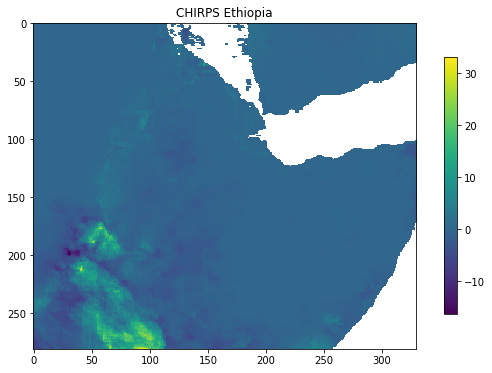

In [8]:
fig, ax = plt.subplots(figsize = (10,6))
chm_plot = ax.imshow(array, 
                     cmap='viridis')
fig.colorbar(chm_plot, fraction=0.023, ax=ax)
ax.set_title(f"CHIRPS Ethiopia")

In [9]:
print(array[:100])

[[0.         0.         0.         ... 0.28420368 0.21319681 0.11289363]
 [0.         0.         0.         ... 0.25325757 0.18962261 0.11921257]
 [0.         0.         0.         ... 0.28511906 0.22480138 0.15365757]
 ...
 [0.         0.         0.         ...        nan        nan        nan]
 [0.         0.         0.         ...        nan        nan        nan]
 [0.         0.         0.         ...        nan        nan        nan]]


# Convert CHIRPS GeoTiff to tabular format

In [12]:
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
from osgeo import gdal
from osgeo import gdalconst

def raster2gpd(InRaster,feature_name,band=1,nodataval=-9999):
    '''
    Description: 
        Takes the path of a raster (.tiff) file and produces a Geopandas Data Frame.
    Params:
        - InRaster: the path of the input raster file
        - feature_name: the name of the feature represented by the pixel values 
    '''

    # open the raster and get some properties
    ds       = gdal.OpenShared(InRaster,gdalconst.GA_ReadOnly)
    GeoTrans = ds.GetGeoTransform()
    ColRange = range(ds.RasterXSize)
    RowRange = range(ds.RasterYSize)
    rBand    = ds.GetRasterBand(band) # first band
    nData    = rBand.GetNoDataValue()
    if nData == None:
        print(f"No nodataval found, setting to {nodataval}")
        nData = np.float32(nodataval) # set it to something if not set
    else:
        print(f"Nodataval is: {nData}")

    # specify the center offset (takes the point in middle of pixel)
    HalfX    = GeoTrans[1] / 2
    HalfY    = GeoTrans[5] / 2

    # Check that NoDataValue is of the same type as the raster data
    RowData = rBand.ReadAsArray(0,0,ds.RasterXSize,1)[0]
    if type(nData) != type(RowData[0]):
        print(f"NoData type mismatch: NoDataValue is type {type(nData)} and raster data is type {type(RowData[0])}")
        

    points = []
    for ThisRow in RowRange:
        RowData = rBand.ReadAsArray(0,ThisRow,ds.RasterXSize,1)[0]
        for ThisCol in ColRange:
            # need to exclude NaN values since there is no nodataval
            if (RowData[ThisCol] != nData) and not (np.isnan(RowData[ThisCol])):
                
                # TODO: implement filters on valid pixels
                # for example, the below would ensure pixel values are between -100 and 100
                #if (RowData[ThisCol] <= 100) and (RowData[ThisCol] >= -100):

                X = GeoTrans[0] + ( ThisCol * GeoTrans[1] )
                Y = GeoTrans[3] + ( ThisRow * GeoTrans[5] ) # Y is negative so it's a minus
                # this gives the upper left of the cell, offset by half a cell to get centre
                X += HalfX
                Y += HalfY

                points.append([Point(X, Y),X,Y,RowData[ThisCol],feature_name])

    return gpd.GeoDataFrame(points, columns=['geometry','longitude','latitude','feature_value','feature_name'])

In [13]:
gdf = raster2gpd('CHIRPS_sample.tiff','rainfall')

No nodataval found, setting to -9999


In [15]:
gdf.head()

,geometry,longitude,latitude,feature_value,feature_name
0,POINT (33.53719 16.47725),33.537188,16.477245,0.0,rainfall
1,POINT (33.58710 16.47725),33.587095,16.477245,0.0,rainfall
2,POINT (33.63700 16.47725),33.637003,16.477245,0.0,rainfall
3,POINT (33.68691 16.47725),33.686910,16.477245,0.0,rainfall
4,POINT (33.73682 16.47725),33.736818,16.477245,0.0,rainfall
